In [2]:
import os
# import annoy
import re
import json
import requests
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from typing import List, Tuple

from generator import *
from visualization import *

In [2]:
tmp = {'id' : [], 'type' : []}
with open('F:/Projects/ai-stylist/data/polyvore_outfits/polyvore_item_metadata.json', 'r') as f:
    txt = json.load(f)
    for id, metadata in txt.items():
        tmp['id'].append(id)
        tmp['type'].append(metadata["semantic_category"])
df = pd.DataFrame.from_dict(tmp)
df = df.set_index('id')

FileNotFoundError: [Errno 2] No such file or directory: 'F:/Projects/ai-stylist/data/polyvore_outfits/polyvore_item_metadata.json'

In [3]:
generator = FashionEmbeddingGenerator()
generator.to(device='cuda')

def img_folder2embeds(data_path, batch_size: int=512):
    tmp = {'id': [], 'embed': []}
    file_paths = os.listdir(data_path)

    for idx in tqdm(range(0, len(file_paths), batch_size)):
        batch = file_paths[idx:idx + batch_size]
        ids = list(map(lambda x: re.sub(r'\.jpg$', '', x), batch))
        images = list(map(lambda x: Image.open(os.path.join(data_path, x)), batch))
        embeds = generator.img2embed(images)

        tmp['id'] += ids
        tmp['embed'] += embeds

    embed_df = pd.DataFrame.from_dict(tmp)
    embed_df = df.set_index('id')
    return embed_df

Some weights of the model checkpoint at patrickjohncyh/fashion-clip were not used when initializing CLIPVisionModelWithProjection: ['text_model.encoder.layers.5.self_attn.out_proj.bias', 'text_model.encoder.layers.4.mlp.fc2.weight', 'text_model.encoder.layers.1.layer_norm2.weight', 'text_model.encoder.layers.7.self_attn.q_proj.bias', 'text_model.encoder.layers.4.self_attn.v_proj.weight', 'text_model.encoder.layers.7.self_attn.k_proj.weight', 'text_model.encoder.layers.9.layer_norm2.bias', 'text_model.encoder.layers.4.self_attn.k_proj.weight', 'text_model.encoder.layers.9.layer_norm2.weight', 'text_model.encoder.layers.6.self_attn.k_proj.weight', 'text_model.encoder.layers.6.self_attn.q_proj.weight', 'text_model.encoder.layers.1.self_attn.out_proj.bias', 'text_model.encoder.layers.8.self_attn.v_proj.bias', 'text_model.encoder.layers.7.layer_norm2.bias', 'text_model.embeddings.position_ids', 'text_model.encoder.layers.4.self_attn.out_proj.bias', 'text_model.encoder.layers.3.self_attn.k_p

In [4]:
# data_path = 'F:/Projects/ai-stylist/data/polyvore_outfits/images'
# embed_df = img_folder2embeds(data_path)

In [5]:
# df = df.merge(embed_df, how='outer', on='left')

In [11]:
df = pd.read_json('../data/polyvore_cleaned/top_ids.json').reset_index()

In [12]:
df.columns = ['id', 'embed']

In [13]:
data_path = 'F:/Projects/2023-ai-stylist/data/polyvore_outfits/images'

query


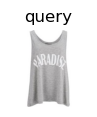

most_similar G.T


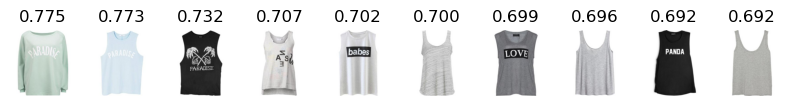

least_similar G.T


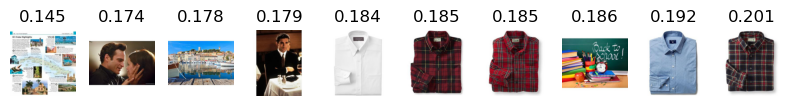

In [14]:
query_idx = 512
query = df.iloc[query_idx]
df['sim'] = df.apply(lambda x: torch.nn.CosineSimilarity(dim=0)(torch.Tensor(x['embed']), torch.Tensor(query['embed'])), axis=1)

n=10

print('query')
query_file_name = str(query['id']) + '.jpg'
show_single_image(data_path, query_file_name)

print('most_similar G.T')
most_similar = df.sort_values('sim', ascending=False, ignore_index=True)[1:n + 1]
file_names = list(map(lambda x: str(x) + '.jpg', most_similar['id'].tolist()))
show_top_n_image(data_path, file_names, most_similar['sim'].tolist(), n=n)

print('least_similar G.T')
least_similar = df.sort_values('sim', ascending=True, ignore_index=True)[0:n]
file_names = list(map(lambda x: str(x) + '.jpg', least_similar['id'].tolist()))
show_top_n_image(data_path, file_names, least_similar['sim'].tolist(), n=n)

Query : a photo of work and business style clothes
Most similar


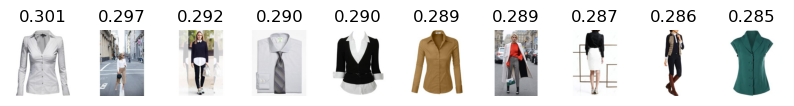

Least similar


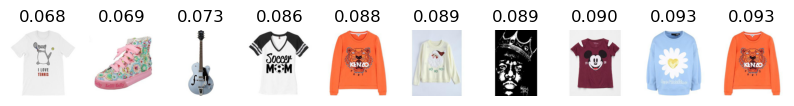

In [18]:
query_txt = "a photo of work and business style clothes"
query_embed = generator.text2embed(query_txt)[0]

df['sim'] = df.apply(lambda x: torch.nn.CosineSimilarity(dim=0)(torch.Tensor(x['embed']), torch.Tensor(query_embed)), axis=1)

n=10

print('Query : ' + query_txt)

print('Most similar')
most_similar = df.sort_values('sim', ascending=False, ignore_index=True)[1:n + 1]
file_names = list(map(lambda x: str(x) + '.jpg', most_similar['id'].tolist()))
show_top_n_image(data_path, file_names, most_similar['sim'].tolist(), n=n)

print('Least similar')
least_similar = df.sort_values('sim', ascending=True, ignore_index=True)[0:n]
file_names = list(map(lambda x: str(x) + '.jpg', least_similar['id'].tolist()))
show_top_n_image(data_path, file_names, least_similar['sim'].tolist(), n=n)

In [ ]:
# Annoy Initialization
annoy_index = annoy.AnnoyIndex(f=512, metric='angular') # 512 is embed size of CLIP

for i, row in df.iterrows():
    annoy_index.add_item(i, np.array(row['embed']))

annoy_index.build(n_trees=10) # More n_tree helps improve accuracy
annoy_index.save('test.ann')

In [ ]:
# Embedding Vector of Query
query_embed = np.array(query['embed'])
# It outputs 'index' and 'distance' (the smaller, the more similar) for n similar vectors.
get_nns_list = annoy_index.get_nns_by_vector(vector=query_embed, n=n, include_distances=True)

print('most_similar ANN')
file_names = list(map(lambda x: str(df.iloc[x]['id']) + '.jpg', get_nns_list[0]))
show_top_n_image(data_path, file_names, get_nns_list[1], n=n)